# Telecom Churn Prediction - Starter Notebook

**Author:** Akshay Sehgal (www.akshaysehgal.com)

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [2]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables.

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [4]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example:

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [9]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [11]:
data.sample(5)

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
57361  57361        109             0.0             0.0             0.0   
16501  16501        109             0.0             0.0             0.0   
16892  16892        109             0.0             0.0             0.0   
18998  18998        109             0.0             0.0             0.0   
17952  17952        109             0.0             0.0             0.0   

      last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
57361            6/30/2014            7/31/2014            8/31/2014  292.729   
16501            6/30/2014            7/31/2014            8/31/2014  162.872   
16892            6/30/2014            7/31/2014            8/31/2014  681.817   
18998            6/30/2014            7/31/2014            8/31/2014  274.036   
17952            6/30/2014            7/31/2014            8/31/2014   62.370   

        arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  \
57361  183.212  ...            0            0        NaN        NaN   
16501  103.383  ...            0            0        NaN        NaN   
16892  727.339  ...            0            0        NaN        NaN   
18998  202.229  ...            0            0        NaN        NaN   
17952   32.533  ...            0            0        NaN        NaN   

       fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
57361        NaN   486         0.0         0.0         0.0                  1  
16501        NaN  1958         0.0         0.0         0.0                  0  
16892        NaN   708         0.0         0.0         0.0                  0  
18998        0.0   202         0.0         0.0         0.0                  0  
17952        NaN   639         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables.

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

In [14]:
# ids = ['id','circle_id']
# total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
# total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
# offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
# average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
# average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
# volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
# volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
# age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

# #Storing them in a single flat list
# variables = [*ids,
#              *total_amounts,
#              *total_outgoing_minutes,
#              *offnetwork_minutes,
#              *average_revenue_3g,
#              *average_revenue_2g,
#              *volume_3g,
#              *volume_2g,
#              *age_on_network,
#              'churn_probability']

# Assuming df is your DataFrame and it has a column named 'id'
data.set_index('id', inplace=True)

# Verify the changes
print(data.head())


    circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
id                                                              
0         109             0.0             0.0             0.0   
1         109             0.0             0.0             0.0   
2         109             0.0             0.0             0.0   
3         109             0.0             0.0             0.0   
4         109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
id                                                                           
0             6/30/2014            7/31/2014            8/31/2014   31.277   
1             6/30/2014            7/31/2014            8/31/2014    0.000   
2             6/30/2014            7/31/2014            8/31/2014   60.806   
3             6/30/2014            7/31/2014            8/31/2014  156.362   
4             6/30/2014            7/31/2014            8/31/2014  240.708  

In [16]:
data.sample(5)

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
id                                                                 
17112        109             0.0             0.0             0.0   
18215        109             0.0             0.0             0.0   
13844        109             0.0             0.0             0.0   
10526        109             0.0             0.0             0.0   
26711        109             0.0             0.0             0.0   

      last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
id                                                                              
17112            6/30/2014            7/31/2014            8/31/2014  107.599   
18215            6/30/2014            7/31/2014            8/31/2014    0.000   
13844            6/30/2014            7/31/2014            8/31/2014    0.000   
10526            6/30/2014            7/31/2014            8/31/2014  242.301   
26711            6/30/2014            7/31/2014            8/31/2014   87.012   

        arpu_7   arpu_8  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  \
id                       ...                                                   
17112   63.287    0.330  ...            0            0        NaN        NaN   
18215  124.606    0.000  ...            0            0        NaN        NaN   
13844  209.745    0.000  ...            0            0        NaN        NaN   
10526  183.546  457.534  ...            0            0        1.0        1.0   
26711  177.047  121.106  ...            0            0        NaN        1.0   

       fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
id                                                                             
17112        NaN   446        0.00        0.00        0.00                  1  
18215        NaN  1431        0.00        0.00        0.00                  0  
13844        NaN  2372        0.00        0.00        0.00                  1  
10526        1.0  2840      723.49      478.33      273.65                  0  
26711        1.0   493        0.00        0.00        0.00                  0  

[5 rows x 171 columns]

Let's look at each variable's datatype:

In [19]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 171 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    circle_id                 int64  
 1    loc_og_t2o_mou            float64
 2    std_og_t2o_mou            float64
 3    loc_ic_t2o_mou            float64
 4    last_date_of_month_6      object 
 5    last_date_of_month_7      object 
 6    last_date_of_month_8      object 
 7    arpu_6                    float64
 8    arpu_7                    float64
 9    arpu_8                    float64
 10   onnet_mou_6               float64
 11   onnet_mou_7               float64
 12   onnet_mou_8               float64
 13   offnet_mou_6              float64
 14   offnet_mou_7              float64
 15   offnet_mou_8              float64
 16   roam_ic_mou_6             float64
 17   roam_ic_mou_7             float64
 18   roam_ic_mou_8             float64
 19   roam_og_mou_6             float64
 20   roam_og_m

Let's also summarize the features using the df.describe method:

In [22]:
data.describe(include="all")

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count     69999.0         69297.0         69297.0         69297.0   
unique        NaN             NaN             NaN             NaN   
top           NaN             NaN             NaN             NaN   
freq          NaN             NaN             NaN             NaN   
mean        109.0             0.0             0.0             0.0   
std           0.0             0.0             0.0             0.0   
min         109.0             0.0             0.0             0.0   
25%         109.0             0.0             0.0             0.0   
50%         109.0             0.0             0.0             0.0   
75%         109.0             0.0             0.0             0.0   
max         109.0             0.0             0.0             0.0   

       last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
count                 69999                69600                69266   
unique                    1                    1                    1   
top               6/30/2014            7/31/2014            8/31/2014   
freq                  69999                69600                69266   
mean                    NaN                  NaN                  NaN   
std                     NaN                  NaN                  NaN   
min                     NaN                  NaN                  NaN   
25%                     NaN                  NaN                  NaN   
50%                     NaN                  NaN                  NaN   
75%                     NaN                  NaN                  NaN   
max                     NaN                  NaN                  NaN   

              arpu_6        arpu_7        arpu_8  ...   sachet_3g_7  \
count   69999.000000  69999.000000  69999.000000  ...  69999.000000   
unique           NaN           NaN           NaN  ...           NaN   
top              NaN           NaN           NaN  ...           NaN   
freq             NaN           NaN           NaN  ...           NaN   
mean      283.134365    278.185912    278.858826  ...      0.081444   
std       334.213918    344.366927    351.924315  ...      0.634547   
min     -2258.709000  -1289.715000   -945.808000  ...      0.000000   
25%        93.581000     86.714000     84.095000  ...      0.000000   
50%       197.484000    191.588000    192.234000  ...      0.000000   
75%       370.791000    365.369500    369.909000  ...      0.000000   
max     27731.088000  35145.834000  33543.624000  ...     33.000000   

         sachet_3g_8     fb_user_6     fb_user_7     fb_user_8           aon  \
count   69999.000000  17568.000000  17865.000000  18417.000000  69999.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        0.085487      0.916325      0.909544      0.890319   1220.639709   
std         0.680035      0.276907      0.286842      0.312501    952.426321   
min         0.000000      0.000000      0.000000      0.000000    180.000000   
25%         0.000000      1.000000      1.000000      1.000000    468.000000   
50%         0.000000      1.000000      1.000000      1.000000    868.000000   
75%         0.000000      1.000000      1.000000      1.000000   1813.000000   
max        41.000000      1.000000      1.000000      1.000000   4337.000000   

          aug_vbc_3g    jul_vbc_3g   jun_vbc_3g  churn_probability  
count   69999.000000  69999.000000  69999.00000       69999.000000  
unique           NaN           NaN          NaN                NaN  
top              NaN           NaN          NaN                NaN  
freq             NaN           NaN          NaN                NaN  
mean       68.108597     65.935830     60.07674           0.101887  
std       269.328659    267.899034    257.22681           0.302502  
min  

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [25]:
data['circle_id'].unique()

array([109], dtype=int64)

In [27]:
X = data.drop(['circle_id'],axis =1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 169), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 169), (14000, 169), (55999,), (14000,))

In [32]:
X_train.head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
id                                                                           
69687             0.0             0.0             0.0            6/30/2014   
11769             0.0             0.0             0.0            6/30/2014   
59638             0.0             0.0             0.0            6/30/2014   
31743             0.0             0.0             0.0            6/30/2014   
25341             0.0             0.0             0.0            6/30/2014   

      last_date_of_month_7 last_date_of_month_8   arpu_6    arpu_7   arpu_8  \
id                                                                            
69687            7/31/2014            8/31/2014    0.000    88.631  116.175   
11769            7/31/2014            8/31/2014    0.000   232.503    0.000   
59638            7/31/2014            8/31/2014  186.499  1226.387  211.668   
31743            7/31/2014            8/31/2014   36.000    77.337   80.300   
25341            7/31/2014            8/31/2014  408.966   195.860  329.836   

       onnet_mou_6  ...  sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  \
id                  ...                                                     
69687         0.00  ...            0            0            0        NaN   
11769         0.00  ...            0            0            0        NaN   
59638         8.89  ...            0            0            0        NaN   
31743         2.39  ...            0            0            0        NaN   
25341        11.98  ...            0            0            0        1.0   

       fb_user_7  fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
id                                                                     
69687        NaN        NaN  1055        0.00        0.00        0.00  
11769        1.0        NaN  1538      228.98      166.09      276.07  
59638        NaN        NaN   791        0.00        0.00        0.00  
31743        NaN        NaN   378        0.00        0.00        0.00  
25341        1.0        1.0  1039        0.00        0.00        0.00  

[5 rows x 169 columns]

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

In [35]:
msno.bar(X_train)

<Axes: >

In [36]:
msno.matrix(X_train)

<Axes: >

Lets also calculate the % missing data for each column:

In [39]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

loc_og_t2o_mou           0.991089
std_og_t2o_mou           0.991089
loc_ic_t2o_mou           0.991089
last_date_of_month_6     0.000000
last_date_of_month_7     0.566082
                          ...    
fb_user_8               73.553099
aon                      0.000000
aug_vbc_3g               0.000000
jul_vbc_3g               0.000000
jun_vbc_3g               0.000000
Length: 169, dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [43]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=139)

In [45]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 139)

In [47]:
# Assuming df is your DataFrame
numerical_cols = X_train_filtered.select_dtypes(include=['number']).columns
categorical_cols = X_train_filtered.select_dtypes(exclude=['number']).columns

# Verify which categorical columns exist in the DataFrame
existing_categorical_cols = [col for col in categorical_cols if col in X_train_filtered.columns]

print("Categorical columns to drop:", existing_categorical_cols)

# Drop these existing categorical columns
X_train_filtered = X_train_filtered.drop(columns=existing_categorical_cols)

# Verify the result
print(X_train_filtered.head())
print("Updated DataFrame columns:", X_train_filtered.columns)



Categorical columns to drop: ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
       loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou   arpu_6    arpu_7  \
id                                                                         
69687             0.0             0.0             0.0    0.000    88.631   
11769             0.0             0.0             0.0    0.000   232.503   
59638             0.0             0.0             0.0  186.499  1226.387   
31743             0.0             0.0             0.0   36.000    77.337   
25341             0.0             0.0             0.0  408.966   195.860   

        arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  ...  \
id                                                                   ...   
69687  116.175         0.00         0.00         9.95          0.00  ...   
11769    0.000         0.00         0.00         0.00          0.00 

In [49]:
categorical_cols = X_train_filtered.select_dtypes(exclude=['number']).columns
print(categorical_cols)

Index([], dtype='object')


In [51]:
from sklearn.impute import SimpleImputer

# Median Imputation for Numerical Columns
median_imputer = SimpleImputer(strategy='median')
X_train_filtered[numerical_cols] = median_imputer.fit_transform(X_train_filtered[numerical_cols])

print(X_train_filtered.isnull().sum())  # Check for remaining missing values


loc_og_t2o_mou    0
std_og_t2o_mou    0
loc_ic_t2o_mou    0
arpu_6            0
arpu_7            0
                 ..
sachet_3g_8       0
aon               0
aug_vbc_3g        0
jul_vbc_3g        0
jun_vbc_3g        0
Length: 133, dtype: int64


In [53]:
X_train_filtered.shape

(55999, 133)

In [55]:
X_train_filtered.describe()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou        arpu_6  \
count         55999.0         55999.0         55999.0  55999.000000   
mean              0.0             0.0             0.0    283.605391   
std               0.0             0.0             0.0    337.822478   
min               0.0             0.0             0.0  -2258.709000   
25%               0.0             0.0             0.0     93.678000   
50%               0.0             0.0             0.0    198.386000   
75%               0.0             0.0             0.0    370.968000   
max               0.0             0.0             0.0  27731.088000   

             arpu_7        arpu_8   onnet_mou_6   onnet_mou_7   onnet_mou_8  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     278.273426    279.246091    130.183114    130.551900    128.595408   
std      344.635963    357.012518    297.652765    308.903926    310.168076   
min    -1289.715000   -491.545000      0.000000      0.000000      0.000000   
25%       86.913500     83.768500      8.130000      7.340000      7.430000   
50%      192.442000    192.780000     34.430000     32.440000     32.180000   
75%      366.481500    371.426000    113.650000    109.570000    106.640000   
max    35145.834000  33543.624000   7376.710000   8011.910000  10752.560000   

       offnet_mou_6  ...  monthly_3g_6  monthly_3g_7  monthly_3g_8  \
count  55999.000000  ...  55999.000000  55999.000000  55999.000000   
mean     194.726708  ...      0.077162      0.078501      0.082341   
std      309.305283  ...      0.363756      0.386311      0.384048   
min        0.000000  ...      0.000000      0.000000      0.000000   
25%       36.800000  ...      0.000000      0.000000      0.000000   
50%       96.730000  ...      0.000000      0.000000      0.000000   
75%      223.890000  ...      0.000000      0.000000      0.000000   
max     6712.810000  ...      9.000000     16.000000     16.000000   

        sachet_3g_6   sachet_3g_7   sachet_3g_8           aon    aug_vbc_3g  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean       0.075519      0.081073      0.084591   1220.815354     67.677246   
std        0.575796      0.625396      0.635063    952.788851    270.063693   
min        0.000000      0.000000      0.000000    180.000000      0.000000   
25%        0.000000      0.000000      0.000000    468.000000      0.000000   
50%        0.000000      0.000000      0.000000    868.000000      0.000000   
75%        0.000000      0.000000      0.000000   1813.000000      0.000000   
max       29.000000     33.000000     30.000000   4337.000000  12916.220000   

         jul_vbc_3g    jun_vbc_3g  
count  55999.000000  55999.000000  
mean      66.129631     60.522017  
std      269.855844    258.709160  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max     9165.600000  11166.210000  

[8 rows x 133 columns]

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

In [58]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

<Axes: >

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [60]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [61]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

<Axes: >

In [62]:
X_train_filtered1.dtypes

loc_og_t2o_mou    float64
std_og_t2o_mou    float64
loc_ic_t2o_mou    float64
arpu_6            float64
arpu_7            float64
                   ...   
sachet_3g_8       float64
aon               float64
aug_vbc_3g        float64
jul_vbc_3g        float64
jun_vbc_3g        float64
Length: 133, dtype: object

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [64]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

In [65]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=numerical_cols))

<Axes: >

You can perform feature transformations at this stage.

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html

Lets also plot the correlations for each feature for bivariate analysis.

In [67]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=numerical_cols).corr())

<Axes: >

In [68]:
#Distribution for the churn probability
sns.histplot(y_train)

<Axes: xlabel='churn_probability', ylabel='Count'>

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [70]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [79]:
# Convert the scaled NumPy array back to a DataFrame
X_train_filtered2 = pd.DataFrame(X_train_filtered2, columns=numerical_cols)

# Check the DataFrame
print(X_train_filtered2.head())


   loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou    arpu_6    arpu_7  \
0             0.0             0.0             0.0 -1.046664 -0.688518   
1             0.0             0.0             0.0 -1.046664 -0.144991   
2             0.0             0.0             0.0 -0.339572  3.609752   
3             0.0             0.0             0.0 -0.910174 -0.731185   
4             0.0             0.0             0.0  0.503889 -0.283423   

     arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  ...  \
0 -0.575227    -0.558219    -0.544268    -0.493891     -0.773436  ...   
1 -1.005003    -0.558219    -0.544268    -0.540689     -0.773436  ...   
2 -0.221961    -0.515729     4.382809     1.754426      0.541245  ...   
3 -0.707942    -0.546796    -0.530148    -0.513927     -0.667851  ...   
4  0.215189    -0.500960    -0.482707    -0.488530     -0.276999  ...   

   monthly_3g_6  monthly_3g_7  monthly_3g_8  sachet_3g_6  sachet_3g_7  \
0     -0.247587     -0.243984     -0.251863      

In [80]:
feature_importances = pd.DataFrame({'col':numerical_cols, 'importance':rf.feature_importances_})
feature_importances

col  importance
0    loc_og_t2o_mou    0.000000
1    std_og_t2o_mou    0.000000
2    loc_ic_t2o_mou    0.000000
3            arpu_6    0.010087
4            arpu_7    0.011998
..              ...         ...
128     sachet_3g_8    0.000506
129             aon    0.012406
130      aug_vbc_3g    0.002098
131      jul_vbc_3g    0.001902
132      jun_vbc_3g    0.001862

[133 rows x 2 columns]

In [81]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

<BarContainer object of 133 artists>

At this step, you can create a bunch of features based on business understanding, such as
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

In [87]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

In [88]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

<Axes: >

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

In [91]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)


plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

<BarContainer object of 133 artists>

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [94]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [95]:
lr.score(pca_components[:,:2], y_train)

0.8980160360006428

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [97]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [98]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [99]:
pipe.fit(X_train_filtered2[numerical_cols], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [101]:
new_vars = numerical_cols
train_score = pipe.score(X_train_filtered2[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9009982321112877


In [102]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9017142857142857


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [111]:
confusion_matrix(y_train, pipe.predict(X_train_filtered2[new_vars]))

array([[49692,   596],
       [ 4948,   763]], dtype=int64)

In [113]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[11980,   599],
       [  777,   644]], dtype=int64)

In [115]:
class_counts = y_train.value_counts()

# Display the class counts
print("Class counts:\n", class_counts)


Class counts:
 churn_probability
0    50288
1     5711
Name: count, dtype: int64


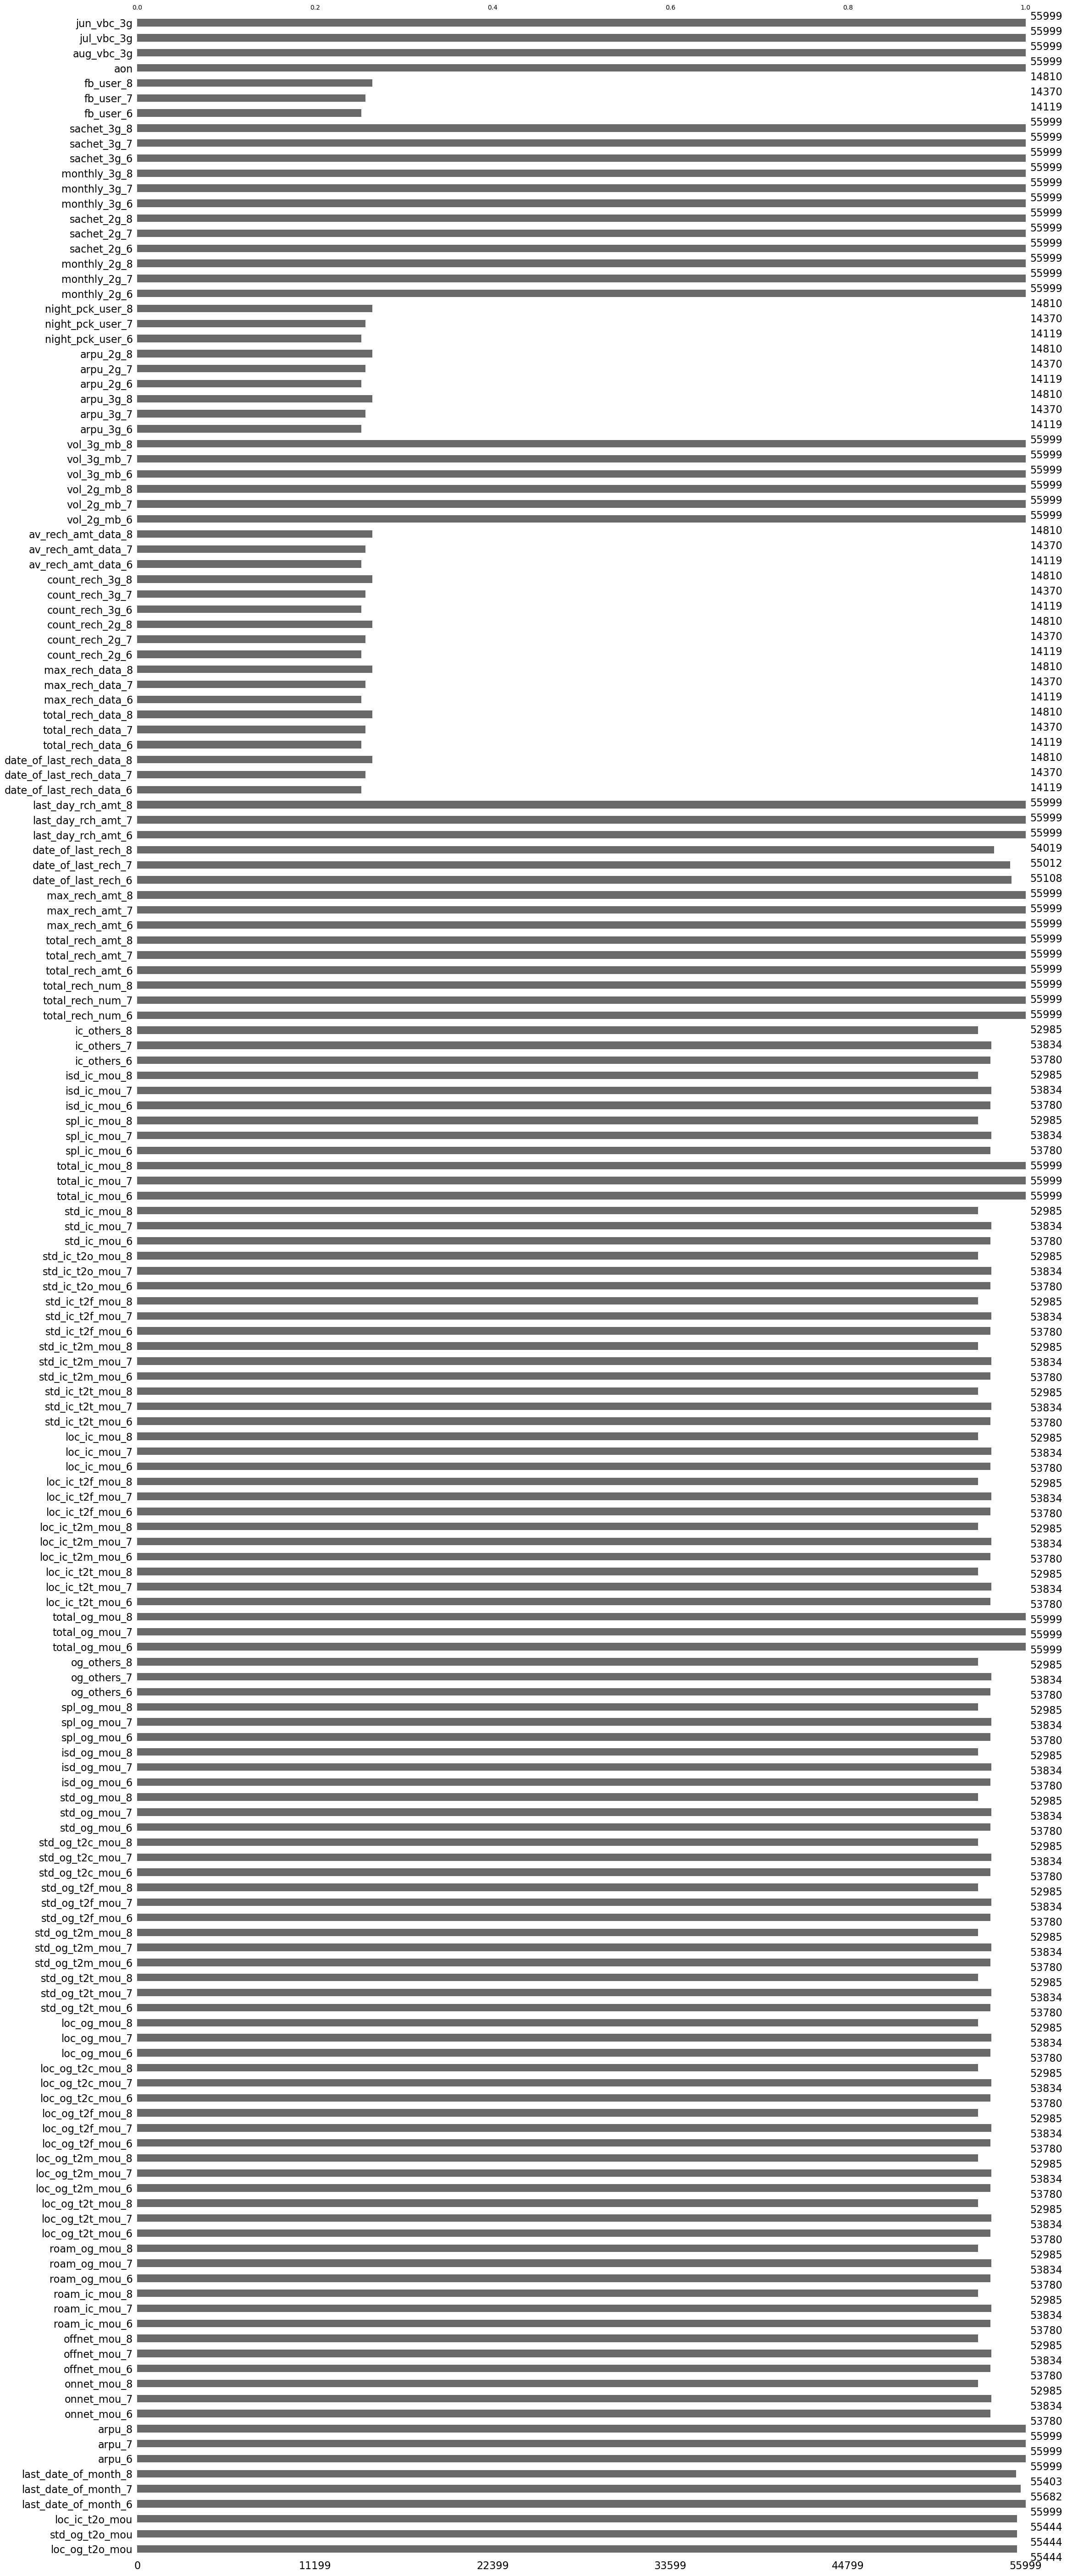

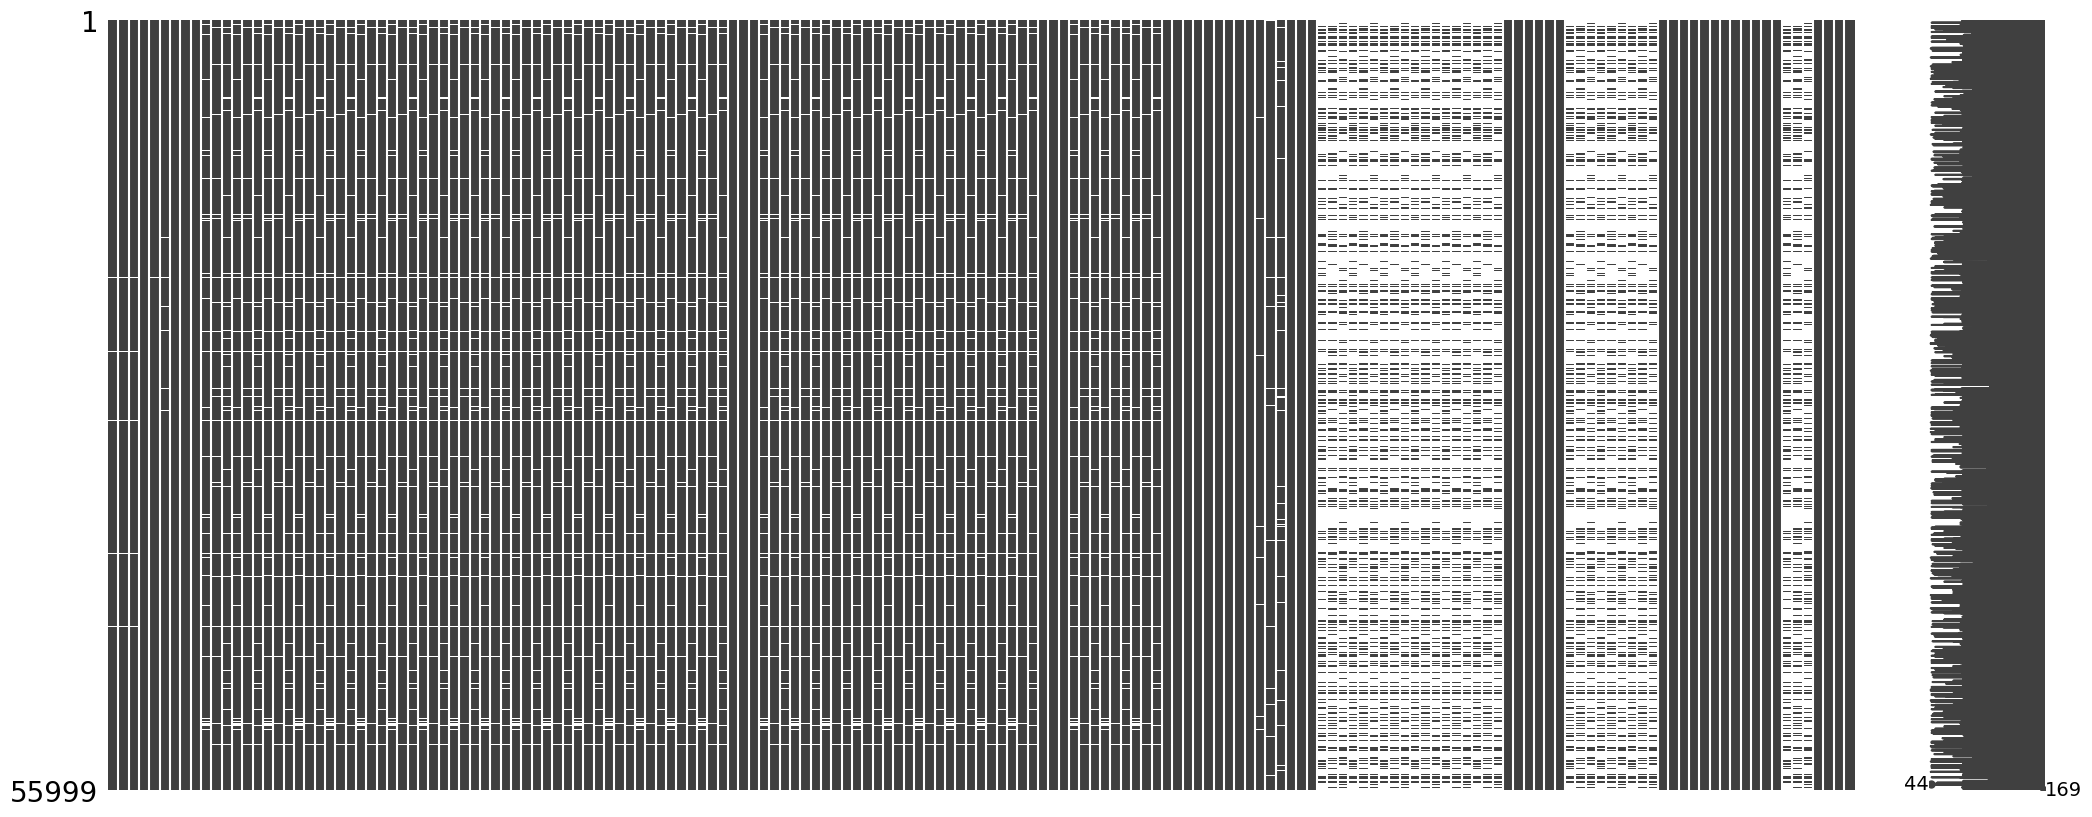

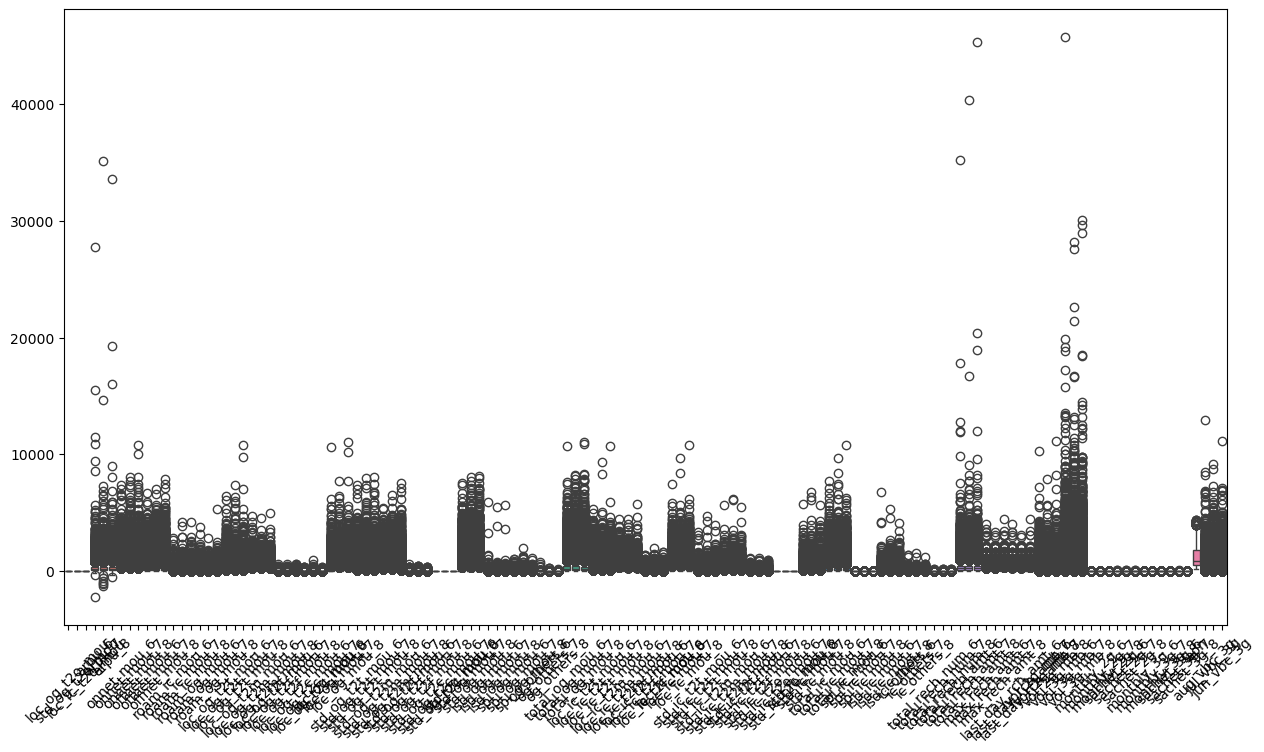

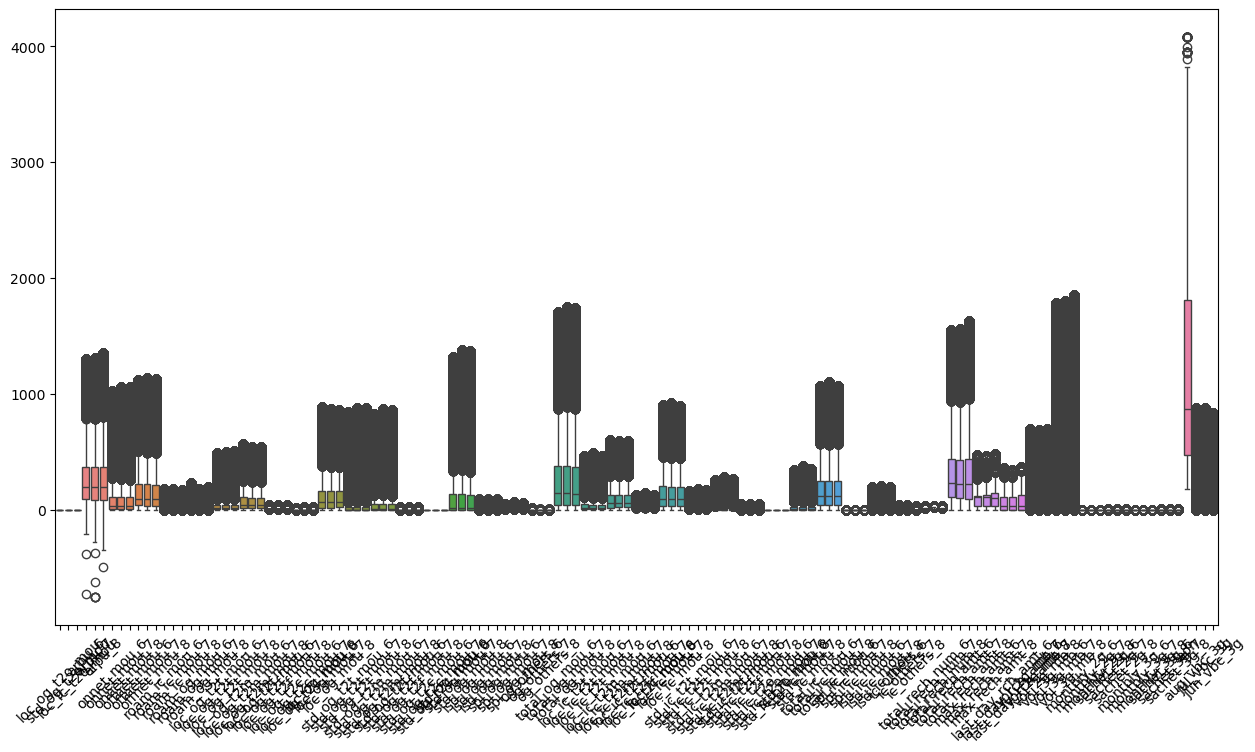

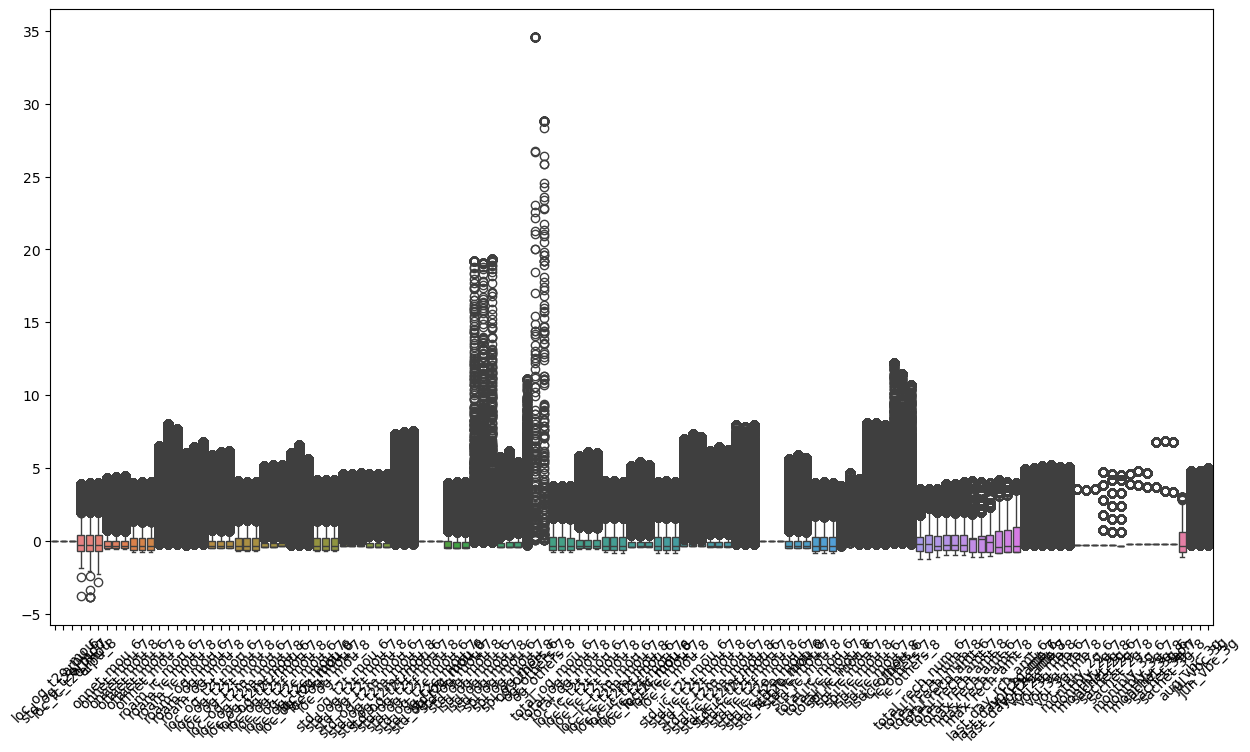

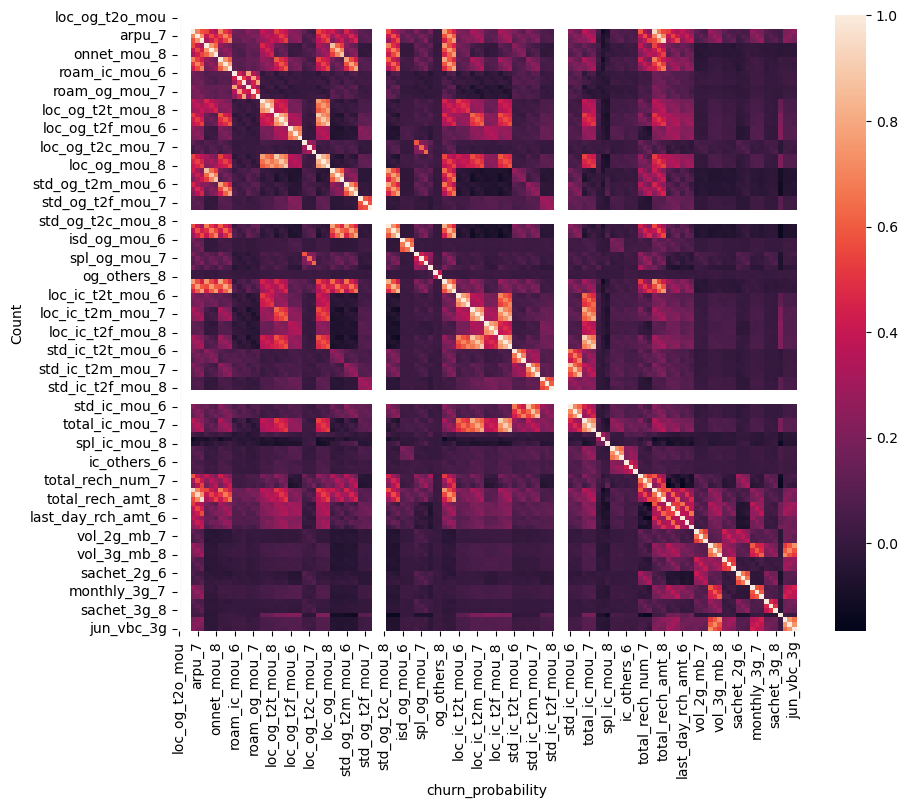

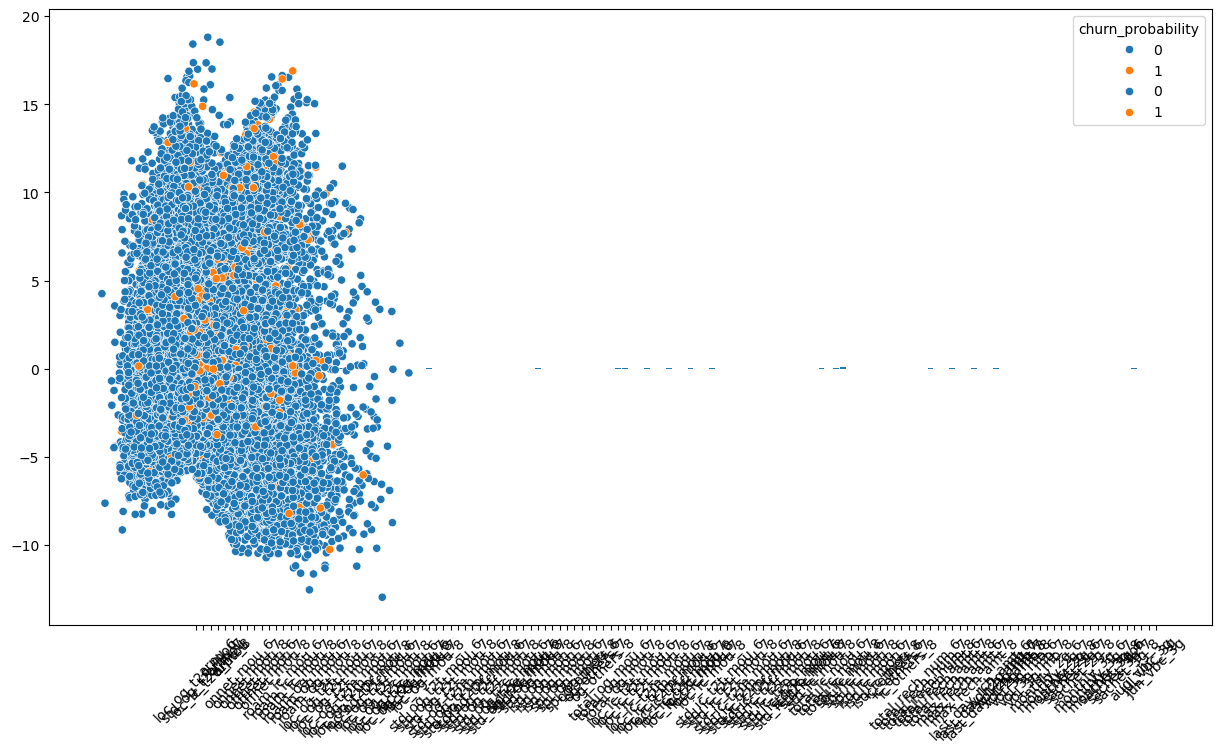

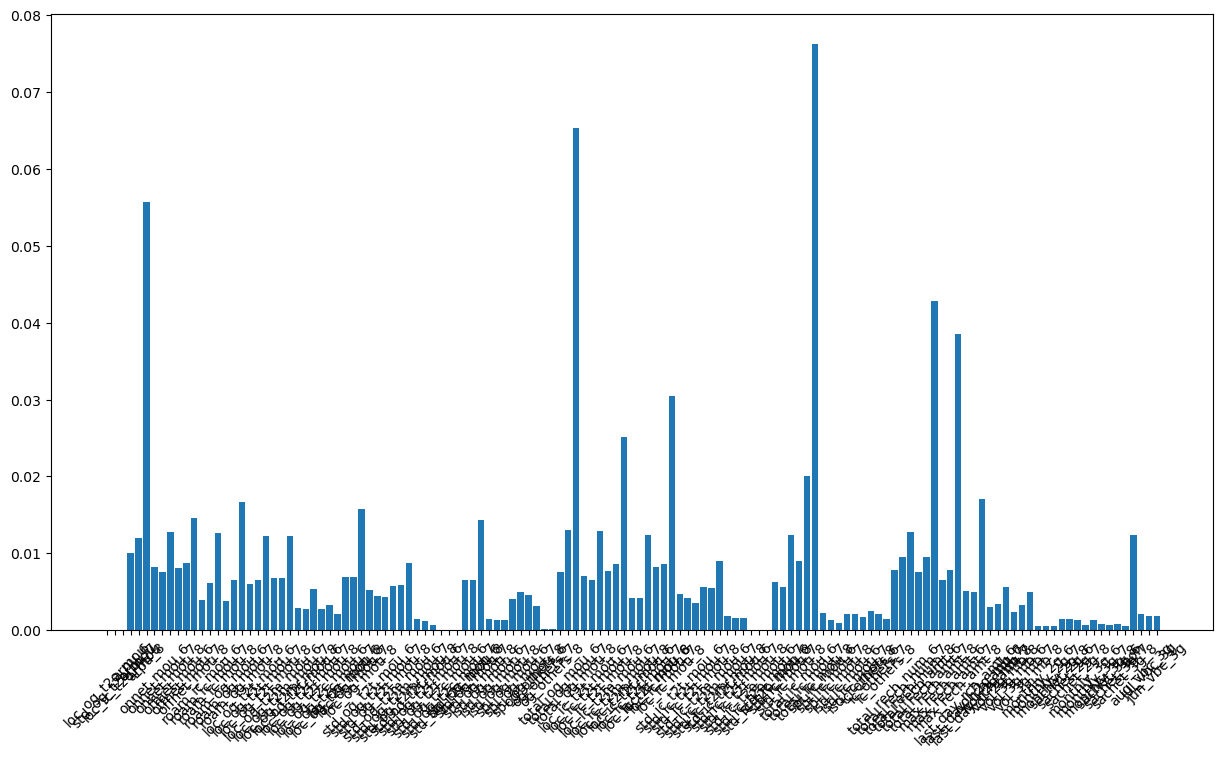

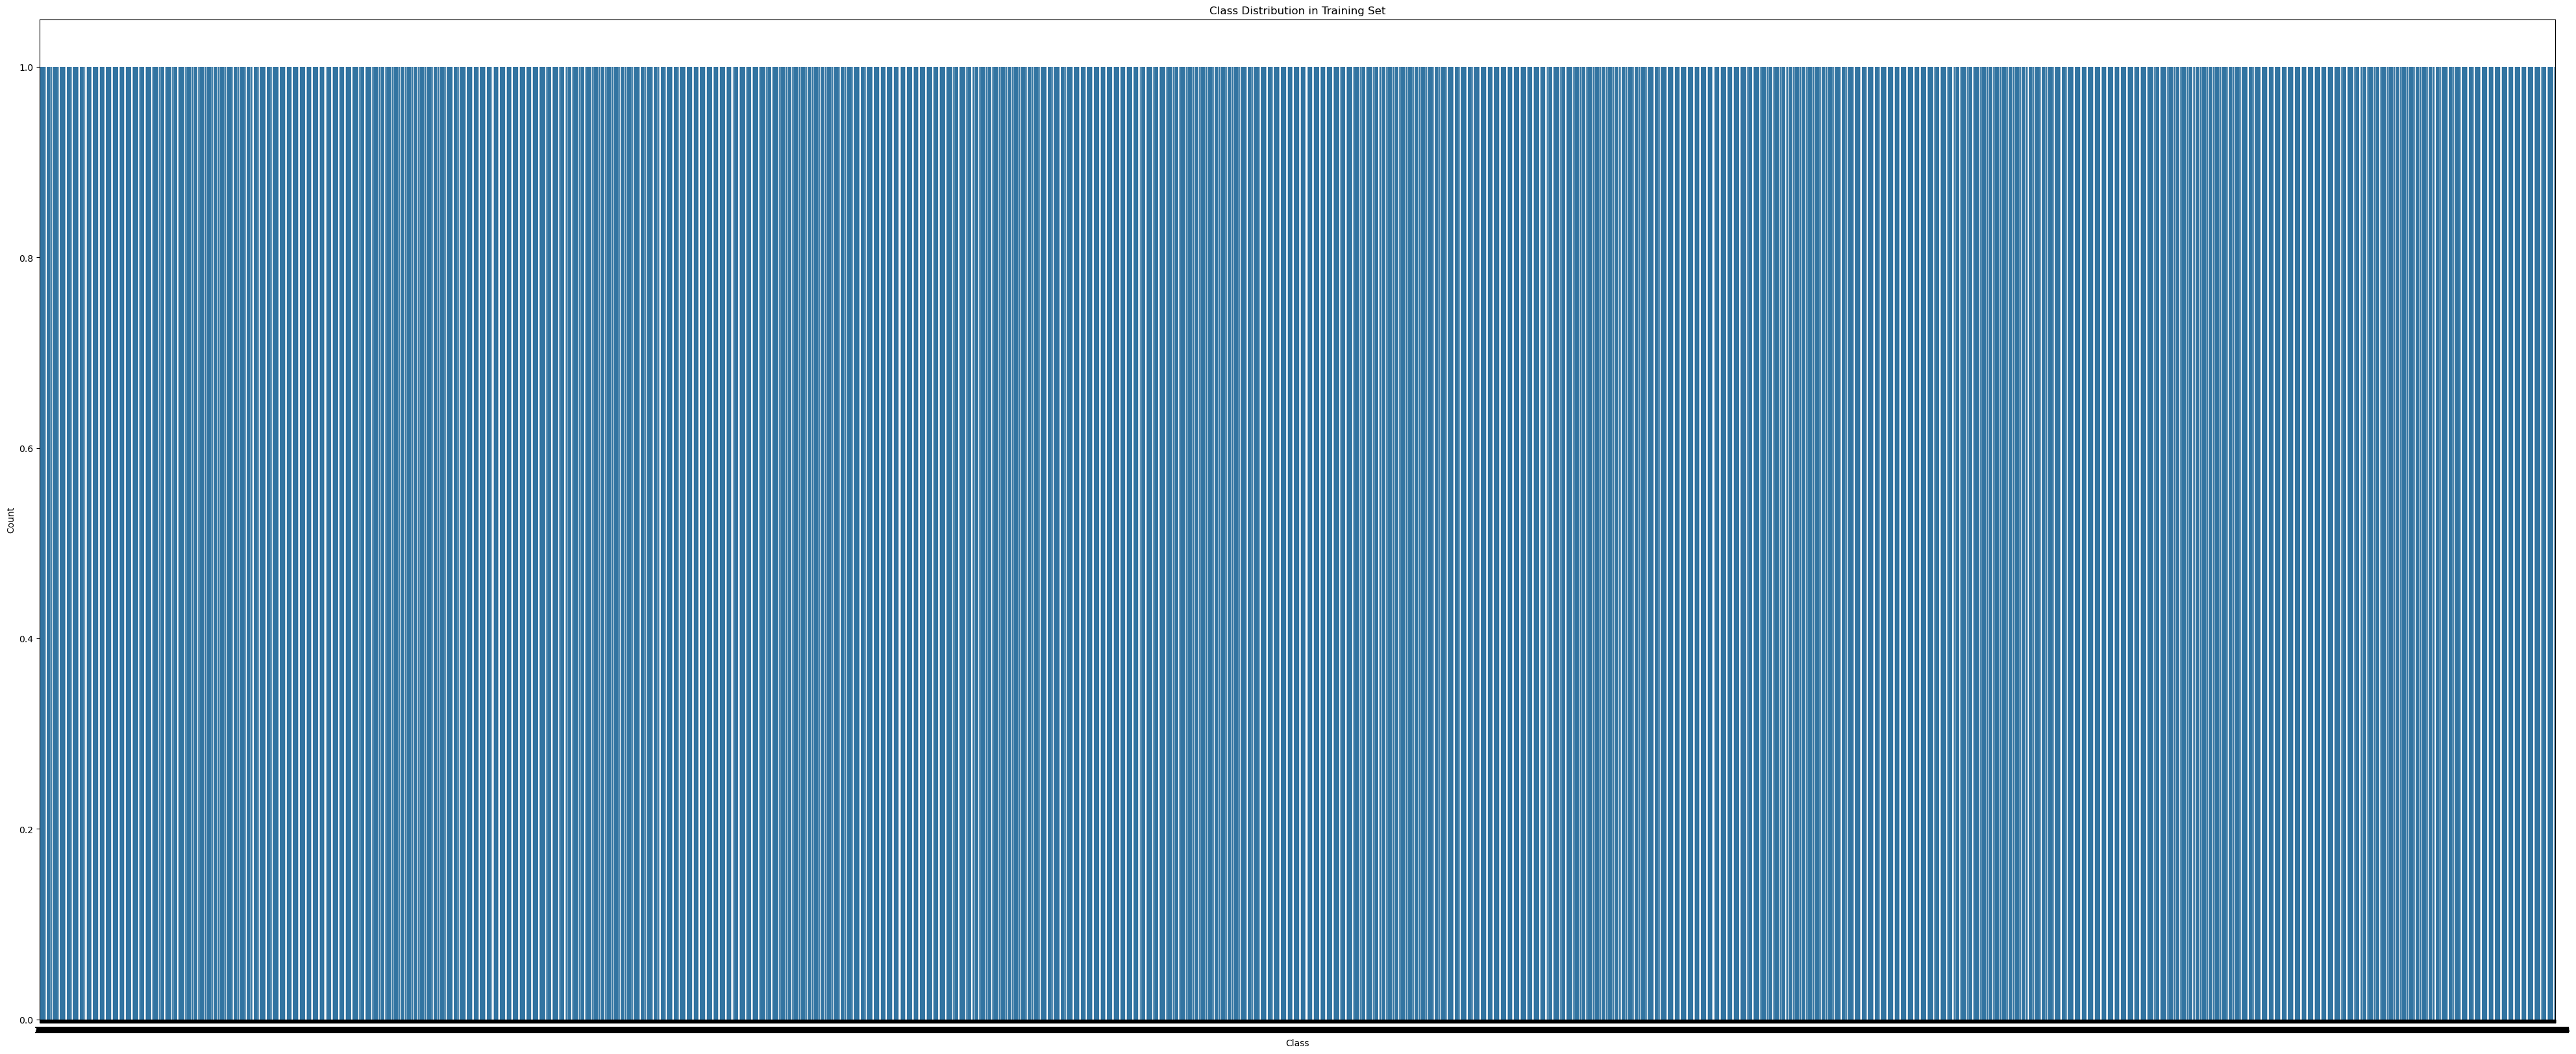

In [117]:
# Create a bar plot for class distribution
plt.figure(figsize=(50, 20))
sns.countplot(y_train)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [118]:
from imblearn.over_sampling import SMOTE
# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filtered2, y_train)

# Check the resampled class distribution
print("Resampled class distribution:\n", pd.Series(y_train_resampled).value_counts())


Resampled class distribution:
 churn_probability
0    50288
1    50288
Name: count, dtype: int64


In [119]:
pipe.fit(X_train_resampled[new_vars], y_train_resampled)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [120]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.4880239520958084

In [121]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.45883180858550315

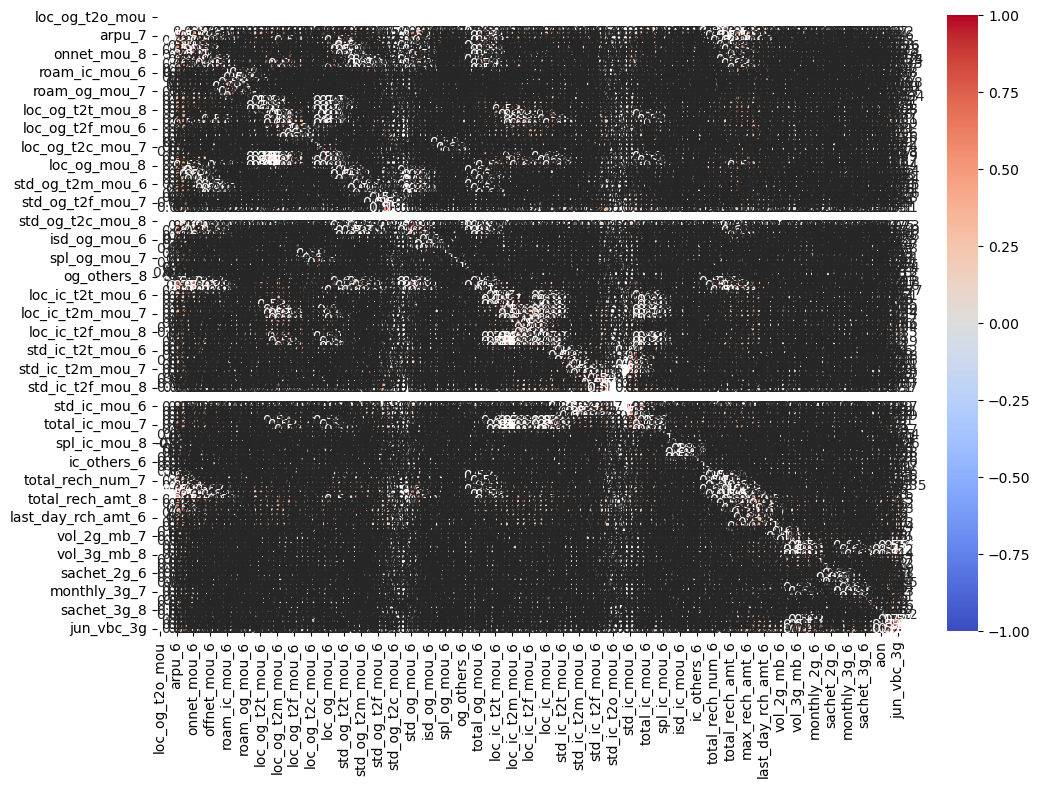

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming x_train_resampled is a DataFrame
corr_matrix = X_train_resampled.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


In [126]:
X_train_resampled.shape

(100576, 133)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Initialize the model with the best hyperparameters
rfc = RandomForestClassifier(bootstrap=True, random_state=100,
                             max_depth=10, min_samples_split=170,
                             class_weight='balanced')

# Fit the model
rfc.fit(X_train, y_train)


# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [ ]:
sample.head()

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [ ]:
unseen.head()

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [ ]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

In [ ]:
submission_data.head()

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [ ]:
unseen['churn_probability'] = rfc.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [ ]:
output.to_csv('submission.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.